100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


300. Hz


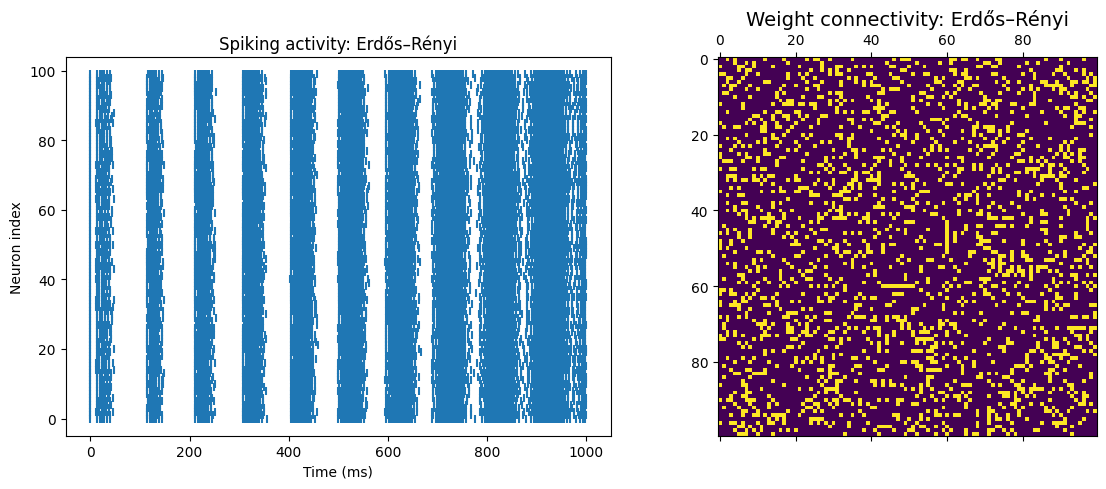

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


300. Hz


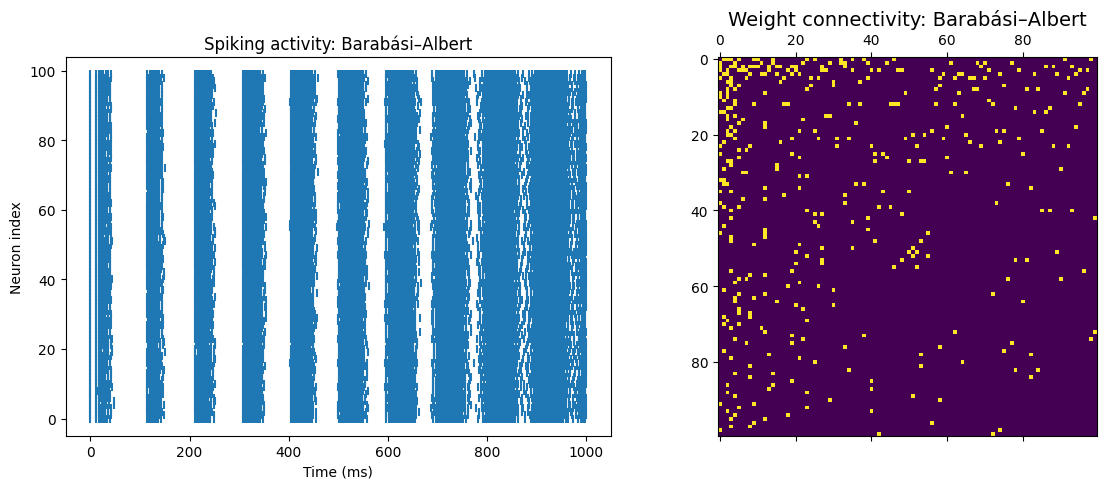

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


300. Hz


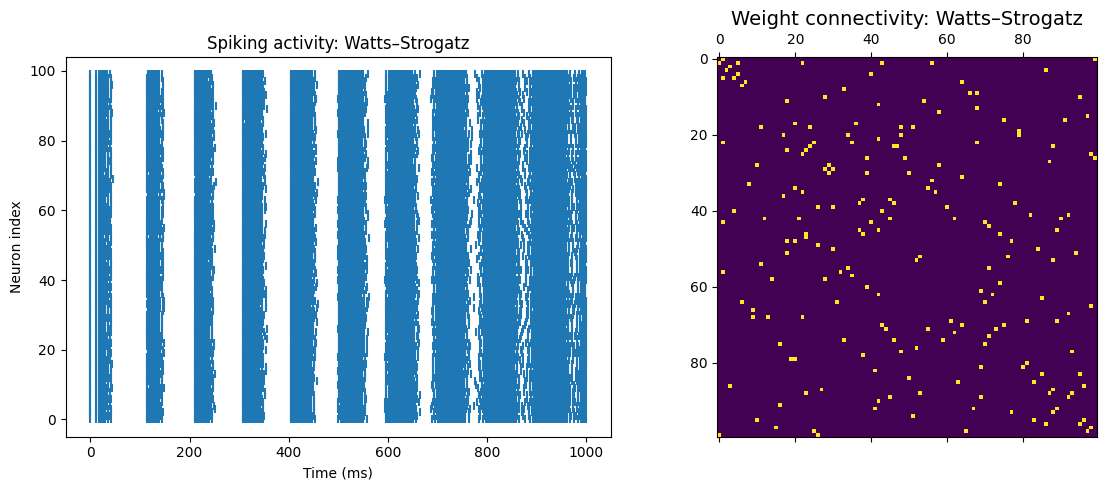

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


300. Hz


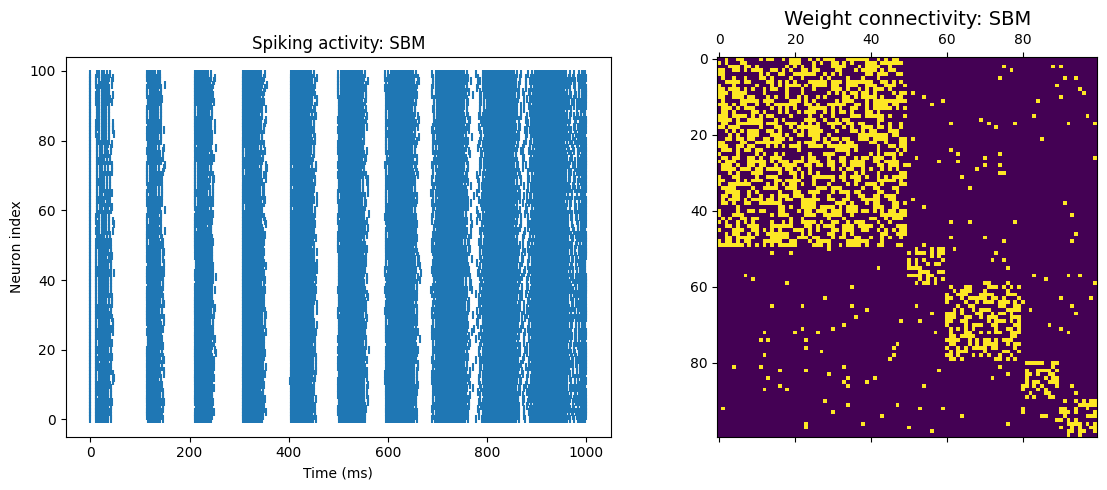

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from brian2 import *


def ER_unweighted(num_of_nodes, p, undirected=False): 
    # p -- prob.of an edge existence
    A_ER = np.zeros((num_of_nodes, num_of_nodes))
    
    if undirected:
        for i in tqdm(range(num_of_nodes)): 
            for j in range(i):
                if np.random.rand() < p: 
                    A_ER[i,j] = 1
        A_ER = A_ER+A_ER.T

    else: 
        for i in tqdm(range(num_of_nodes)): 
            for j in range(num_of_nodes):
                if np.random.rand() < p: 
                    A_ER[i,j] = 1
        np.fill_diagonal(A_ER, 0)


    return A_ER # return adjacency matrix


# Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to m existing nodes. 
# The higher node degree, the higher probability of the connection. The final number of nodes is n

#You start from a star graph with m + 1 nodes. In each step you create m edges between a new node and existing nodes. The probability of connection to the node i is 
#p(i) =k_i \sum k

def attach(node, G, m):
    edges = G.edges()
    uniform = []
    for edge in edges:
        uniform.append(edge[0])
        uniform.append(edge[1])
    curr_edge_count = 0
    edges = []
    while curr_edge_count < m:
        curr_node = np.random.choice(uniform)
        if [node, curr_node] not in edges:
            edges.append([node, curr_node])
            curr_edge_count += 1
    for edge in edges:
        G.add_edge(edge[0], edge[1])

def barabasi_albert_graph(n, m, random_seed=1, undirected=False):
    if undirected: 
        G = nx.star_graph(m)
        for i in range(1, n - m):
            attach(m + i, G, m)

        G_adj = nx.to_numpy_array(G)
        return G_adj

    else:
        G_in = nx.star_graph(m)
        for i in range(1, n - m):
            attach(m + i, G_in, m)

        G_in_adj = nx.to_numpy_array(G_in)
        G_in_adj = np.triu(G_in_adj)

        G_out = nx.star_graph(m)
        for i in range(1, n - m):
            attach(m + i, G_out, m)

        G_out_adj = nx.to_numpy_array(G_out)
        G_out_adj = np.triu(G_out_adj)


        return G_in_adj.T + G_out_adj
    


# small-world graph model — rewire an edge with probability p in a ring lattice with n nodes and k degree

def ring_lattice(n, k):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    edges = []
    for i in range(n):
        for j in range(n):
            value = abs(i - j)
            if value % (n - 1 - k//2) > 0 and value % (n - 1 - k//2) <= k//2:
                edges.append([i, j])
    G.add_edges_from(edges)
    return G

#Write a function `rewire` that takes in input a ring lattice G, a node, a model parameter k and probability p
#For every right hand side neighbor i, the function rewires an edge (node, i) into a random edge (node, j) with probability p where i != j != node

def rewire(G, node, k, p):
    removed_edges = []
    added_edges = []
    for edge in G.edges(node):
        if edge[1] > edge[0]:
            rewritten_node = np.random.choice(list(G.nodes()))
            if [node, rewritten_node] in G.edges() or node == rewritten_node or [node, rewritten_node] in removed_edges or [node, rewritten_node] in added_edges:
                continue
            else:
                if np.random.random() < p:
                    removed_edges.append(edge)
                    added_edges.append([node, rewritten_node])
    for edge in removed_edges:
        G.remove_edge(edge[0], edge[1])
    for edge in added_edges:
        G.add_edge(edge[0], edge[1])
    return G


def Watts_Strogatz(n, k, p): 
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return nx.to_numpy_array(G)


def Watts_Strogatz_simple_direction(G_adj): 
    directed_G = G_adj.copy()
    for i in range(G_adj.shape[0]):
        for j in range(i): 
            if np.random.randint(0,2) == 0: 
                G_adj[i,j] = 0
            else: 
                G_adj[j,i] = 0
    

    return directed_G



# undirected SBM
# cluster borders
def fram(cluster_sizes, number_of_clusters):
    frames=np.zeros(number_of_clusters)
    frames[0]=cluster_sizes[0]
    
    for i in range(1,number_of_clusters):
        frames[i]=frames[i-1]+cluster_sizes[i]
        
    return frames  


# cluster check
def clcheck(a,cluster_sizes, number_of_clusters):
    if a>=0 and a<fram(cluster_sizes, number_of_clusters)[0]:
        return 0
    else:    
        for i in range(0,number_of_clusters):
            if a>=fram(cluster_sizes, number_of_clusters)[i] and a<fram(cluster_sizes, number_of_clusters)[i+1]:
                return i+1  


# generation of the SBM matrix
def gensbm(number_of_nodes, number_of_clusters, connection_probabilities, cluster_sizes, directed=True, sbm_family=True,
           filtration_params=np.linspace(0.15,0.9,10)):
    sbm=np.zeros((number_of_nodes,number_of_nodes))
    clusters = []
    if directed: 
        if sbm_family: 
            sbms = np.zeros((len(filtration_params), number_of_nodes, number_of_nodes))
            for k in tqdm(range(len(filtration_params))): 
                for i in range(0,number_of_nodes):
                    clusters.append(clcheck(i,cluster_sizes, number_of_clusters))
                    for j in range(0,i):
                        if (k!=0) & ((sbms[k-1,i,j] != 1) and (sbms[k-1,j,i] != 1)): 
                            if clcheck(i,cluster_sizes, number_of_clusters)==clcheck(j,cluster_sizes, number_of_clusters):
                                start_of_the_edge = np.random.choice([i,j])
                                end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                                sbms[k,start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-filtration_params[k], filtration_params[k]])
                            else: 
                                start_of_the_edge = np.random.choice([i,j])
                                end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                                sbms[k,start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-connection_probabilities[0], connection_probabilities[0]])
                        
                        elif k == 0: 
                            if clcheck(i,cluster_sizes, number_of_clusters)==clcheck(j,cluster_sizes, number_of_clusters):
                                start_of_the_edge = np.random.choice([i,j])
                                end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                                sbms[k,start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-filtration_params[k], filtration_params[k]])
                            else: 
                                start_of_the_edge = np.random.choice([i,j])
                                end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                                sbms[k,start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-connection_probabilities[0], connection_probabilities[0]])
                        
                        else:
                            sbms[k,i,j]=sbms[k-1,i,j] 
                            sbms[k,j,i]=sbms[k-1,j,i] 
            return sbms, clusters 
        
        else:
            for i in range(0,number_of_nodes):
                clusters.append(clcheck(i,cluster_sizes, number_of_clusters))
                for j in range(0,i):
                    if clcheck(i,cluster_sizes, number_of_clusters)==clcheck(j,cluster_sizes, number_of_clusters):
                        start_of_the_edge = np.random.choice([i,j])
                        end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                        sbm[start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-connection_probabilities[1], connection_probabilities[1]])
                    else: 
                        start_of_the_edge = np.random.choice([i,j])
                        end_of_the_edge = list(set([i,j]) - set([start_of_the_edge]))[0]
                        sbm[start_of_the_edge,end_of_the_edge]=np.random.choice([0, 1], p=[1-connection_probabilities[0], connection_probabilities[0]]) 
            return sbm, clusters 

    else:
        if sbm_family: 
            sbms = np.zeros((len(filtration_params), number_of_nodes, number_of_nodes))
            for k in range(len(filtration_params)): 
                for i in range(0,number_of_nodes):
                    clusters.append(clcheck(i,cluster_sizes, number_of_clusters))
                    for j in range(0,i):
                        if (sbms[k-1,i,j] != 1) or (sbms[k-1,j,i] != 1):
                            if clcheck(i,cluster_sizes, number_of_clusters)==clcheck(j,cluster_sizes, number_of_clusters):
                                sbms[k,i,j]=np.random.choice([0, 1], p=[1-filtration_params[k], filtration_params[k]])
                                sbms[k,j,i]=sbms[k,i,j]
                            else: 
                                sbms[k,i,j]=np.random.choice([0, 1], p=[1-connection_probabilities[0], connection_probabilities[0]])
                                sbms[k,j,i]=sbms[k,i,j]
                        else:
                            sbms[k,i,j]=sbms[k-1,i,j] 
                            sbms[k,j,i]=sbms[k-1,j,i] 
            return sbms, clusters 

        else: 
            for i in range(0,number_of_nodes):
                clusters.append(clcheck(i,cluster_sizes, number_of_clusters))
                for j in range(0,i):
                    if clcheck(i,cluster_sizes, number_of_clusters)==clcheck(j,cluster_sizes, number_of_clusters):
                        sbm[i,j]=np.random.choice([0, 1], p=[1-connection_probabilities[1], connection_probabilities[1]])
                        sbm[j,i]=sbm[i,j]
                    else: 
                        sbm[i,j]=np.random.choice([0, 1], p=[1-connection_probabilities[0], connection_probabilities[0]])
                        sbm[j,i]=sbm[i,j]
            return sbm, clusters 

# Параметры сетей
N = 100  # число нейронов
N_E = N / 2
# 1) ER
p_er = 0.2
A_ER = ER_unweighted(N, p_er, undirected=True)  

# 2) Barabasi-Albert
m_ba = 2
A_BA = barabasi_albert_graph(N, m_ba, random_seed=1, undirected=True)

# 3) Watts-Strogatz
k_ws = 3
p_ws = 0.9
A_WS = Watts_Strogatz(N, k_ws, p_ws) 
# Сделаем сеть направленной простым образом
A_WS = Watts_Strogatz_simple_direction(A_WS)

# 4) SBM
num_of_clusters = 5
p_of_edge_in_cluster = 0.7
p_of_edge_between_clusters = 0.01
cluster_sizes = [50, 10, 20, 10, 10] 
filtration_params = np.linspace(0.1,0.9,5)
sbms, cluster_labels = gensbm(N, num_of_clusters, 
                             [p_of_edge_between_clusters, p_of_edge_in_cluster], 
                             cluster_sizes, directed=True,
                             sbm_family=True, filtration_params=filtration_params)
A_SBM = sbms[-1,:,:]  # Возьмём последнюю матрицу из набора SBM

# Функция для запуска симуляции, формирования синапсов, мониторинга и вывода результатов
def run_simulation(C_total, network_name):
    start_scope()
    
    tau = 20 * ms
    v_threshold = -50 * mV 
    v_reset = -70*mV      
    v_rest = -65*mV    
    J = 0.1 * mV    
    D = 1.5 * ms     
    defaultclock.dt = 0.1 * ms  
    n_neurons = C_total.shape[0]

    
    C_E = 0.1 * N_E    
    C_ext = int(C_E)   
    nu_ext_over_nu_thr = 1
    g = 4 # коэф. торможения
    v_diff = v_threshold - v_rest  
    nu_thr = v_diff / (J * C_E * tau)

    # Определение группы нейронов
    neurons = NeuronGroup(
        n_neurons,
        '''
        dv/dt = (v_rest - v + v_ext + v_poisson)/tau : volt (unless refractory)
        v_ext = v0 * sin(2*pi*f*t + phi) : volt
        v_poisson : volt
        v0 : volt
        f : Hz
        phi : 1
        ''',
        threshold="v > v_threshold",
        reset="v = v_reset",
        method="euler",
    )

    # Параметры для части нейронов
    neurons.f = 10 * Hz
    neurons.v0 = 0.1 * volt
    neurons.phi = 0

    # Определение синапсов
    exc_synapses = Synapses(neurons, neurons,
                                model="w : 1",
                                on_pre="v_post += J * w",
                                delay=D)
    inhib_synapses = Synapses(neurons, neurons, 
                                model="w : 1", 
                                on_pre="v_post += -g * J * w", 
                                delay=D)


    exc_synapses.connect(condition='i != j and i < N_E')
    inhib_synapses.connect(condition='i != j and i >= N_E')

    nu_ext_group1 = nu_ext_over_nu_thr * nu_thr * 0.2
    print(nu_ext_group1)
    
    external_poisson_input_1 = PoissonInput(
        target=neurons,
        target_var="v_poisson",
        N=C_ext,
        rate= nu_ext_group1,
        weight=J
    )

    # Задание весов согласно матрице C_total
    sources, targets = C_total.nonzero()
    exc_synapses.w[:, :] = 0  # Обнуляем все веса
    inhib_synapses.w[:, :] = 0  # Обнуляем все веса
    # Устанавливаем веса в соответствии с начальной матрицей связности
    for idx in range(len(sources)):
        i = sources[idx]
        j = targets[idx]
        if i < N_E:
            # Возбуждающий синапс
            syn_idx = np.where((exc_synapses.i == i) & (exc_synapses.j == j))[0]
            if len(syn_idx) > 0:
                exc_synapses.w[syn_idx[0]] = 1
        else:
            # Тормозный синапс
            syn_idx = np.where((inhib_synapses.i == i) & (inhib_synapses.j == j))[0]
            if len(syn_idx) > 0:
                inhib_synapses.w[syn_idx[0]] = 1

    spike_monitor = SpikeMonitor(neurons[:100])  

    # Запуск симуляции
    run(1000*ms)

    # Построение графиков
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    ax_spikes = axes[0]
    ax_weights = axes[1]

    # Спайковая активность
    spike_times = spike_monitor.t / ms
    spike_indices = spike_monitor.i
    ax_spikes.scatter(spike_times, spike_indices, marker='|')
    ax_spikes.set_xlabel('Time (ms)')
    ax_spikes.set_ylabel('Neuron index')
    ax_spikes.set_title(f'Spiking activity: {network_name}')

    # Матрица весов
    W = np.zeros((n_neurons, n_neurons))
    W[exc_synapses.i[:], exc_synapses.j[:]] = exc_synapses.w[:]
    W[inhib_synapses.i[:], inhib_synapses.j[:]] = inhib_synapses.w[:]
    ax_weights.set_title(f'Weight connectivity: {network_name}', fontsize=14)
    ax_weights.matshow(W, cmap='viridis')
    plt.tight_layout()
    plt.show()

# Последовательный запуск 4 сетей
run_simulation(A_ER, "Erdős–Rényi")
run_simulation(A_BA, "Barabási–Albert")
run_simulation(A_WS, "Watts–Strogatz")
run_simulation(A_SBM, "SBM")